In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" # all | last | last_expr | none 

In [3]:
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

### Data preparation and model configuration

In [4]:
# ============= Import required packaages ==============
import re, time, os

# Import all custom variables and modules
from custom_classes_defs.preprocessing import *
# from custom_classes_defs.Unet_like import *   
# from custom_classes_defs.fnet import *
from custom_classes_defs.hed import *

import keras
import numpy as np

from keras.utils import plot_model

RND_STATE = 247
BATCH_SIZE = 32
keras.utils.set_random_seed(RND_STATE)

INTERACTIVE_SESSION = True

# import keras_tuner as kt

# from tensorflow.data import Dataset as tf_data
# -------------------------------------------------------

In [5]:
# Verify CPU setup
print(f"tensorflow version: {tf.__version__}")
print(f"keras version: {keras.__version__}")
print(tf.config.list_physical_devices('CPU'))

# Verify GPU setup
print(tf.config.list_physical_devices('GPU'))

tensorflow version: 2.15.0
keras version: 2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[]


In [6]:
pets = Oxford_Pets(
        input_dir = "./data/images/",
        target_dir = "./data/annotations/trimaps/",
        img_size = (160, 160),
        batch_size = BATCH_SIZE
    )

train_dataset, valid_dataset, test_dataset = \
        pets.split_data(seed=RND_STATE)

#for input_path, target_path in zip(pets.input_img_paths[:10], pets.target_img_paths[:10]):
#    print(input_path, "|", target_path)
print(f"training data (size = {len(train_dataset)*BATCH_SIZE})")
print(f"validation data (size = {len(valid_dataset)*BATCH_SIZE})")
print(f"test data (size = {len(test_dataset)*BATCH_SIZE})")
print("Data images tensor:",train_dataset.element_spec[0])
print("Data labels tensor:",train_dataset.element_spec[1])


Number of samples: 7390
training data (size = 672)
validation data (size = 96)
test data (size = 6656)
Data images tensor: TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None)
Data labels tensor: TensorSpec(shape=(None, 160, 160, 1), dtype=tf.uint8, name=None)


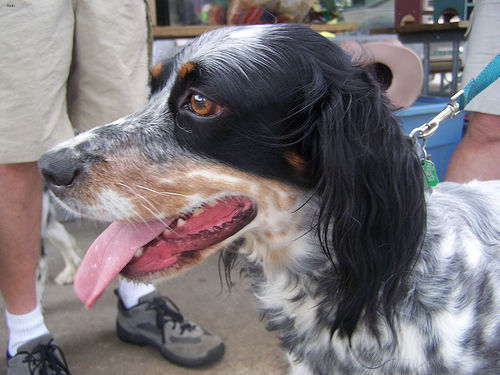

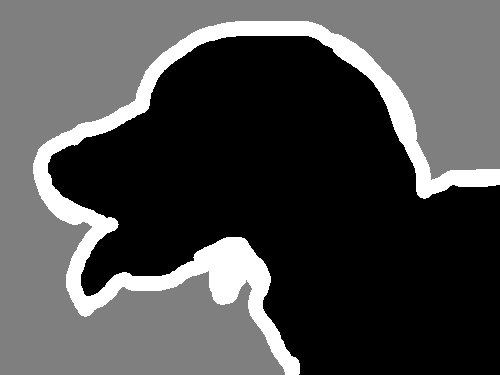

In [7]:
# Display input image #idx
idx = 19
display(Image(filename=pets.input_img_paths[idx]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(pets.target_img_paths[idx]))
display(img)

In [8]:

# Model configurations
conf = model_config(
    epochs=30,
    batch_size=BATCH_SIZE,
    shuffle=False,
    scaling=1,
    verbose=1,
    save_path='./data',
    augmentation=False,
    img_shape=pets.img_size,
    target_size=pets.img_size,
    channels_dim=(3,3),
    new_training_session=True
)


es_callbacks = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

callbacks = [
    #keras.callbacks.ModelCheckpoint("oxford_segmentation.keras", save_best_only=True),
    es_callbacks
]

conf.set( validation_data=valid_dataset,  callbacks=callbacks )
conf.set(
    'compile',
    optimizer=tf.keras.optimizers.legacy.Adam(1e-4), 
    loss="sparse_categorical_crossentropy"
)
conf.info()

        compile_args:
                     optimizer: <class 'keras.src.optimizers.legacy.adam.Adam'>
                          loss: sparse_categorical_crossentropy
       training_args:
                        epochs: 30
                    batch_size: 32
                       shuffle: False
                       verbose: 1
               validation_data: <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
                     callbacks: <class 'tensorflow.python.trackable.data_structures.ListWrapper'>
          model_arch:
                     img_shape: (160, 160)
                   target_size: (160, 160)
                  channels_dim: (3, 3)
                       scaling: 1
                  augmentation: False
new_training_session: True
           save_path: ./data
           threshold: 0.5
           pos_label: 1


In [9]:
# ### Interactive step:
# if INTERACTIVE_SESSION:
#     train = input("New train session? (y/n): ")
#     if train[0].lower()=='y':
#         conf.new_training_session = True
#     else:
#         conf.new_training_session = False
#     interact = input("Are you sure, you want to run this session interactively? (y/n): ")
#     if interact[0].lower()!='y':
#         INTERACTIVE_SESSION = False

### Build model

In [10]:
print("\n\n{}\n\t{}\n{}".format('='*55,f'Build model', '-'*55))
# m_obj = UNET2D(panel_sizes=[32,64,128,256], model_arch=conf.model_arch)
m_obj = HED2D(num_freeze=4, model_arch=conf.model_arch)
model = m_obj.build_model()
# model.summary()
plot_model(model, 'm_obj.png',show_shapes=True)
num_trainable_weights = sum([np.prod(w.shape) for w in model.trainable_weights])
print(f"Total number of parameters: {model.count_params():,}")
print(f"Total trainable wieghts: {num_trainable_weights:,}")
print(f"Total non-trainable wieghts: {model.count_params()-num_trainable_weights:,}")





	Build model
-------------------------------------------------------


Total number of parameters: 14,716,313
Total trainable wieghts: 7,081,049
Total non-trainable wieghts: 7,635,264


### Train the model



	Train hed model
-------------------------------------------------------
Model training...
Epoch 1/30


 1/21 [>.............................] - ETA: 4:39 - loss: 106.2741

 2/21 [=>............................] - ETA: 3:36 - loss: 105.0818

 3/21 [===>..........................] - ETA: 3:32 - loss: 102.4829

 4/21 [====>.........................] - ETA: 3:09 - loss: 100.2883

 5/21 [======>.......................] - ETA: 2:59 - loss: 98.9597 

 6/21 [=======>......................] - ETA: 2:43 - loss: 98.0666

 7/21 [=========>....................] - ETA: 2:32 - loss: 98.8572

 8/21 [==========>...................] - ETA: 2:19 - loss: 98.2410

 9/21 [===========>..................] - ETA: 2:08 - loss: 98.3220

10/21 [=============>................] - ETA: 1:56 - loss: 97.9341

11/21 [==============>...............] - ETA: 1:46 - loss: 97.5836

12/21 [================>.............] - ETA: 1:34 - loss: 97.4703

13/21 [=================>............] - ETA: 1:24 - loss: 97.4845

14/21 [===================>..........] - ETA: 1:13 - loss: 96.8565

15/21 [====================>.........] - ETA: 1:02 - loss: 96.3228

16/21 [=====================>........] - ETA: 51s - loss: 96.5792 

17/21 [=======================>......] - ETA: 41s - loss: 96.7020

18/21 [========================>.....] - ETA: 30s - loss: 95.9605

19/21 [==========================>...] - ETA: 20s - loss: 95.8072

20/21 [===========================>..] - ETA: 10s - loss: 95.8641

21/21 [==============================] - ETA: 0s - loss: 95.9256 

21/21 [==============================] - 219s 10s/step - loss: 95.9256 - val_loss: 87.3147


Epoch 2/30


 1/21 [>.............................] - ETA: 46s - loss: 93.8374

 2/21 [=>............................] - ETA: 42s - loss: 92.7764

 3/21 [===>..........................] - ETA: 39s - loss: 90.5866

 4/21 [====>.........................] - ETA: 37s - loss: 88.6189

 5/21 [======>.......................] - ETA: 36s - loss: 87.4150

 6/21 [=======>......................] - ETA: 33s - loss: 86.5744

 7/21 [=========>....................] - ETA: 31s - loss: 87.2299

 8/21 [==========>...................] - ETA: 29s - loss: 86.6523

 9/21 [===========>..................] - ETA: 27s - loss: 86.6919

10/21 [=============>................] - ETA: 25s - loss: 86.3495

11/21 [==============>...............] - ETA: 23s - loss: 86.0100

12/21 [================>.............] - ETA: 22s - loss: 85.8993

13/21 [=================>............] - ETA: 20s - loss: 85.8887

14/21 [===================>..........] - ETA: 18s - loss: 85.3027

15/21 [====================>.........] - ETA: 15s - loss: 84.8066

16/21 [=====================>........] - ETA: 13s - loss: 85.0261

17/21 [=======================>......] - ETA: 10s - loss: 85.1282

18/21 [========================>.....] - ETA: 8s - loss: 84.4560 

19/21 [==========================>...] - ETA: 5s - loss: 84.3010

20/21 [===========================>..] - ETA: 2s - loss: 84.3375

21/21 [==============================] - ETA: 0s - loss: 84.3897

21/21 [==============================] - 62s 3s/step - loss: 84.3897 - val_loss: 76.4887


Epoch 3/30


 1/21 [>.............................] - ETA: 57s - loss: 82.2114

 2/21 [=>............................] - ETA: 50s - loss: 81.2764

 3/21 [===>..........................] - ETA: 49s - loss: 79.4674

 4/21 [====>.........................] - ETA: 48s - loss: 77.7203

 5/21 [======>.......................] - ETA: 47s - loss: 76.6436

 6/21 [=======>......................] - ETA: 44s - loss: 75.8603

 7/21 [=========>....................] - ETA: 41s - loss: 76.3981

 8/21 [==========>...................] - ETA: 39s - loss: 75.8629

 9/21 [===========>..................] - ETA: 36s - loss: 75.8693

10/21 [=============>................] - ETA: 33s - loss: 75.5736

11/21 [==============>...............] - ETA: 29s - loss: 75.2507

12/21 [================>.............] - ETA: 27s - loss: 75.1481

13/21 [=================>............] - ETA: 24s - loss: 75.1195

14/21 [===================>..........] - ETA: 21s - loss: 74.5789

15/21 [====================>.........] - ETA: 18s - loss: 74.1219

16/21 [=====================>........] - ETA: 15s - loss: 74.3113

17/21 [=======================>......] - ETA: 11s - loss: 74.3979

18/21 [========================>.....] - ETA: 8s - loss: 73.7945 

19/21 [==========================>...] - ETA: 5s - loss: 73.6416

20/21 [===========================>..] - ETA: 2s - loss: 73.6613

21/21 [==============================] - ETA: 0s - loss: 73.7068

21/21 [==============================] - 66s 3s/step - loss: 73.7068 - val_loss: 66.5471


Epoch 4/30


 1/21 [>.............................] - ETA: 52s - loss: 71.5232

 2/21 [=>............................] - ETA: 50s - loss: 70.7133

 3/21 [===>..........................] - ETA: 47s - loss: 69.2455

 4/21 [====>.........................] - ETA: 44s - loss: 67.7072

 5/21 [======>.......................] - ETA: 41s - loss: 66.7561

 6/21 [=======>......................] - ETA: 38s - loss: 66.0296

 7/21 [=========>....................] - ETA: 36s - loss: 66.4628

 8/21 [==========>...................] - ETA: 33s - loss: 65.9692

 9/21 [===========>..................] - ETA: 30s - loss: 65.9483

10/21 [=============>................] - ETA: 28s - loss: 65.6979

11/21 [==============>...............] - ETA: 26s - loss: 65.3947

12/21 [================>.............] - ETA: 23s - loss: 65.3030

13/21 [=================>............] - ETA: 21s - loss: 65.2618

14/21 [===================>..........] - ETA: 18s - loss: 64.7671

15/21 [====================>.........] - ETA: 15s - loss: 64.3485

16/21 [=====================>........] - ETA: 13s - loss: 64.5135

17/21 [=======================>......] - ETA: 10s - loss: 64.5884

18/21 [========================>.....] - ETA: 8s - loss: 64.0506 

19/21 [==========================>...] - ETA: 5s - loss: 63.9030

20/21 [===========================>..] - ETA: 2s - loss: 63.9084

21/21 [==============================] - ETA: 0s - loss: 63.9492

21/21 [==============================] - 66s 3s/step - loss: 63.9492 - val_loss: 57.5368


Epoch 5/30


 1/21 [>.............................] - ETA: 1:04 - loss: 61.8207

 2/21 [=>............................] - ETA: 58s - loss: 61.1290 

 3/21 [===>..........................] - ETA: 54s - loss: 59.9665

 4/21 [====>.........................] - ETA: 49s - loss: 58.6235

 5/21 [======>.......................] - ETA: 45s - loss: 57.7930

 6/21 [=======>......................] - ETA: 42s - loss: 57.1233

 7/21 [=========>....................] - ETA: 39s - loss: 57.4656

 8/21 [==========>...................] - ETA: 36s - loss: 57.0129

 9/21 [===========>..................] - ETA: 33s - loss: 56.9701

10/21 [=============>................] - ETA: 30s - loss: 56.7625

11/21 [==============>...............] - ETA: 27s - loss: 56.4831

12/21 [================>.............] - ETA: 24s - loss: 56.4026

13/21 [=================>............] - ETA: 22s - loss: 56.3542

14/21 [===================>..........] - ETA: 19s - loss: 55.9062

15/21 [====================>.........] - ETA: 16s - loss: 55.5256

16/21 [=====================>........] - ETA: 13s - loss: 55.6710

17/21 [=======================>......] - ETA: 10s - loss: 55.7370

18/21 [========================>.....] - ETA: 8s - loss: 55.2616 

19/21 [==========================>...] - ETA: 5s - loss: 55.1213

20/21 [===========================>..] - ETA: 2s - loss: 55.1149

21/21 [==============================] - ETA: 0s - loss: 55.1525

21/21 [==============================] - 63s 3s/step - loss: 55.1525 - val_loss: 49.4627


Epoch 6/30


 1/21 [>.............................] - ETA: 54s - loss: 53.1249

 2/21 [=>............................] - ETA: 50s - loss: 52.5459

 3/21 [===>..........................] - ETA: 49s - loss: 51.6496

 4/21 [====>.........................] - ETA: 46s - loss: 50.4837

 5/21 [======>.......................] - ETA: 43s - loss: 49.7713

 6/21 [=======>......................] - ETA: 40s - loss: 49.1573

 7/21 [=========>....................] - ETA: 37s - loss: 49.4235

 8/21 [==========>...................] - ETA: 35s - loss: 49.0106

 9/21 [===========>..................] - ETA: 33s - loss: 48.9519

10/21 [=============>................] - ETA: 30s - loss: 48.7834

11/21 [==============>...............] - ETA: 27s - loss: 48.5297

12/21 [================>.............] - ETA: 24s - loss: 48.4616

13/21 [=================>............] - ETA: 21s - loss: 48.4103

14/21 [===================>..........] - ETA: 19s - loss: 48.0074

15/21 [====================>.........] - ETA: 16s - loss: 47.6642

16/21 [=====================>........] - ETA: 13s - loss: 47.7942

17/21 [=======================>......] - ETA: 10s - loss: 47.8526

18/21 [========================>.....] - ETA: 8s - loss: 47.4352 

19/21 [==========================>...] - ETA: 5s - loss: 47.3046

20/21 [===========================>..] - ETA: 2s - loss: 47.2892

21/21 [==============================] - ETA: 0s - loss: 47.3239

21/21 [==============================] - 63s 3s/step - loss: 47.3239 - val_loss: 42.3188


Epoch 7/30


 1/21 [>.............................] - ETA: 53s - loss: 45.4276

 2/21 [=>............................] - ETA: 50s - loss: 44.9482

 3/21 [===>..........................] - ETA: 48s - loss: 44.2788

 4/21 [====>.........................] - ETA: 46s - loss: 43.2743

 5/21 [======>.......................] - ETA: 44s - loss: 42.6733

 6/21 [=======>......................] - ETA: 41s - loss: 42.1135

 7/21 [=========>....................] - ETA: 39s - loss: 42.3170

 8/21 [==========>...................] - ETA: 36s - loss: 41.9438

 9/21 [===========>..................] - ETA: 34s - loss: 41.8719

10/21 [=============>................] - ETA: 31s - loss: 41.7382

11/21 [==============>...............] - ETA: 28s - loss: 41.5116

12/21 [================>.............] - ETA: 25s - loss: 41.4563

13/21 [=================>............] - ETA: 23s - loss: 41.4068

14/21 [===================>..........] - ETA: 20s - loss: 41.0476

15/21 [====================>.........] - ETA: 17s - loss: 40.7402

16/21 [=====================>........] - ETA: 14s - loss: 40.8583

17/21 [=======================>......] - ETA: 11s - loss: 40.9110

18/21 [========================>.....] - ETA: 8s - loss: 40.5476 

19/21 [==========================>...] - ETA: 5s - loss: 40.4292

20/21 [===========================>..] - ETA: 2s - loss: 40.4077

21/21 [==============================] - ETA: 0s - loss: 40.4407

21/21 [==============================] - 67s 3s/step - loss: 40.4407 - val_loss: 36.0807


Epoch 8/30


 1/21 [>.............................] - ETA: 56s - loss: 38.7008

 2/21 [=>............................] - ETA: 54s - loss: 38.3154

 3/21 [===>..........................] - ETA: 51s - loss: 37.8358

 4/21 [====>.........................] - ETA: 48s - loss: 36.9715

 5/21 [======>.......................] - ETA: 46s - loss: 36.4748

 6/21 [=======>......................] - ETA: 43s - loss: 35.9677

 7/21 [=========>....................] - ETA: 41s - loss: 36.1212

 8/21 [==========>...................] - ETA: 38s - loss: 35.7843

 9/21 [===========>..................] - ETA: 35s - loss: 35.7048

10/21 [=============>................] - ETA: 32s - loss: 35.6015

11/21 [==============>...............] - ETA: 31s - loss: 35.4019

12/21 [================>.............] - ETA: 29s - loss: 35.3599

13/21 [=================>............] - ETA: 26s - loss: 35.3150

14/21 [===================>..........] - ETA: 23s - loss: 34.9984

15/21 [====================>.........] - ETA: 20s - loss: 34.7257

16/21 [=====================>........] - ETA: 16s - loss: 34.8346

17/21 [=======================>......] - ETA: 13s - loss: 34.8816

18/21 [========================>.....] - ETA: 10s - loss: 34.5670

19/21 [==========================>...] - ETA: 6s - loss: 34.4611 

20/21 [===========================>..] - ETA: 3s - loss: 34.4361

21/21 [==============================] - ETA: 0s - loss: 34.4686

21/21 [==============================] - 73s 4s/step - loss: 34.4686 - val_loss: 30.7026


Epoch 9/30


 1/21 [>.............................] - ETA: 58s - loss: 32.9009

 2/21 [=>............................] - ETA: 55s - loss: 32.5952

 3/21 [===>..........................] - ETA: 52s - loss: 32.2692

 4/21 [====>.........................] - ETA: 49s - loss: 31.5271

 5/21 [======>.......................] - ETA: 47s - loss: 31.1246

 6/21 [=======>......................] - ETA: 44s - loss: 30.6678

 7/21 [=========>....................] - ETA: 41s - loss: 30.7811

 8/21 [==========>...................] - ETA: 38s - loss: 30.4793

 9/21 [===========>..................] - ETA: 35s - loss: 30.3961

10/21 [=============>................] - ETA: 32s - loss: 30.3185

11/21 [==============>...............] - ETA: 29s - loss: 30.1445

12/21 [================>.............] - ETA: 26s - loss: 30.1161

13/21 [=================>............] - ETA: 23s - loss: 30.0778

14/21 [===================>..........] - ETA: 20s - loss: 29.8000

15/21 [====================>.........] - ETA: 17s - loss: 29.5600

16/21 [=====================>........] - ETA: 14s - loss: 29.6613

17/21 [=======================>......] - ETA: 11s - loss: 29.7036

18/21 [========================>.....] - ETA: 8s - loss: 29.4324 

19/21 [==========================>...] - ETA: 5s - loss: 29.3389

20/21 [===========================>..] - ETA: 2s - loss: 29.3124

21/21 [==============================] - ETA: 0s - loss: 29.3450

21/21 [==============================] - 67s 3s/step - loss: 29.3450 - val_loss: 26.1195


Epoch 10/30


 1/21 [>.............................] - ETA: 57s - loss: 27.9745

 2/21 [=>............................] - ETA: 52s - loss: 27.7260

 3/21 [===>..........................] - ETA: 57s - loss: 27.5177

 4/21 [====>.........................] - ETA: 54s - loss: 26.8807

 5/21 [======>.......................] - ETA: 50s - loss: 26.5597

 6/21 [=======>......................] - ETA: 46s - loss: 26.1504

 7/21 [=========>....................] - ETA: 42s - loss: 26.2307

 8/21 [==========>...................] - ETA: 39s - loss: 25.9617

 9/21 [===========>..................] - ETA: 36s - loss: 25.8782

10/21 [=============>................] - ETA: 33s - loss: 25.8227

11/21 [==============>...............] - ETA: 30s - loss: 25.6733

12/21 [================>.............] - ETA: 26s - loss: 25.6577

13/21 [=================>............] - ETA: 24s - loss: 25.6260

14/21 [===================>..........] - ETA: 21s - loss: 25.3839

15/21 [====================>.........] - ETA: 18s - loss: 25.1739

16/21 [=====================>........] - ETA: 15s - loss: 25.2685

17/21 [=======================>......] - ETA: 12s - loss: 25.3060

18/21 [========================>.....] - ETA: 9s - loss: 25.0732 

19/21 [==========================>...] - ETA: 6s - loss: 24.9918

20/21 [===========================>..] - ETA: 3s - loss: 24.9659

21/21 [==============================] - ETA: 0s - loss: 24.9987

21/21 [==============================] - 68s 3s/step - loss: 24.9987 - val_loss: 22.2528


Epoch 11/30


 1/21 [>.............................] - ETA: 59s - loss: 23.8175

 2/21 [=>............................] - ETA: 55s - loss: 23.6189

 3/21 [===>..........................] - ETA: 52s - loss: 23.4988

 4/21 [====>.........................] - ETA: 49s - loss: 22.9522

 5/21 [======>.......................] - ETA: 46s - loss: 22.7017

 6/21 [=======>......................] - ETA: 44s - loss: 22.3350

 7/21 [=========>....................] - ETA: 42s - loss: 22.3898

 8/21 [==========>...................] - ETA: 40s - loss: 22.1503

 9/21 [===========>..................] - ETA: 38s - loss: 22.0694

10/21 [=============>................] - ETA: 36s - loss: 22.0323

11/21 [==============>...............] - ETA: 34s - loss: 21.9049

12/21 [================>.............] - ETA: 31s - loss: 21.8994

13/21 [=================>............] - ETA: 27s - loss: 21.8734

14/21 [===================>..........] - ETA: 24s - loss: 21.6634

15/21 [====================>.........] - ETA: 20s - loss: 21.4802

16/21 [=====================>........] - ETA: 17s - loss: 21.5695

17/21 [=======================>......] - ETA: 13s - loss: 21.6030

18/21 [========================>.....] - ETA: 10s - loss: 21.4029

19/21 [==========================>...] - ETA: 6s - loss: 21.3328 

20/21 [===========================>..] - ETA: 3s - loss: 21.3086

21/21 [==============================] - ETA: 0s - loss: 21.3411

21/21 [==============================] - 77s 4s/step - loss: 21.3411 - val_loss: 19.0135


Epoch 12/30


 1/21 [>.............................] - ETA: 1:04 - loss: 20.3343

 2/21 [=>............................] - ETA: 1:03 - loss: 20.1767

 3/21 [===>..........................] - ETA: 1:02 - loss: 20.1180

 4/21 [====>.........................] - ETA: 1:02 - loss: 19.6458

 5/21 [======>.......................] - ETA: 58s - loss: 19.4538 

 6/21 [=======>......................] - ETA: 56s - loss: 19.1255

 7/21 [=========>....................] - ETA: 52s - loss: 19.1614

 8/21 [==========>...................] - ETA: 47s - loss: 18.9481

 9/21 [===========>..................] - ETA: 43s - loss: 18.8716

10/21 [=============>................] - ETA: 39s - loss: 18.8495

11/21 [==============>...............] - ETA: 35s - loss: 18.7422

12/21 [================>.............] - ETA: 31s - loss: 18.7457

13/21 [=================>............] - ETA: 28s - loss: 18.7253

14/21 [===================>..........] - ETA: 24s - loss: 18.5430

15/21 [====================>.........] - ETA: 20s - loss: 18.3835

16/21 [=====================>........] - ETA: 17s - loss: 18.4676

17/21 [=======================>......] - ETA: 13s - loss: 18.4981

18/21 [========================>.....] - ETA: 10s - loss: 18.3270

19/21 [==========================>...] - ETA: 6s - loss: 18.2676 

20/21 [===========================>..] - ETA: 3s - loss: 18.2460

21/21 [==============================] - ETA: 0s - loss: 18.2773

21/21 [==============================] - 79s 4s/step - loss: 18.2773 - val_loss: 16.3106


Epoch 13/30


 1/21 [>.............................] - ETA: 1:22 - loss: 17.4246

 2/21 [=>............................] - ETA: 1:08 - loss: 17.3036

 3/21 [===>..........................] - ETA: 1:02 - loss: 17.2926

 4/21 [====>.........................] - ETA: 57s - loss: 16.8839 

 5/21 [======>.......................] - ETA: 54s - loss: 16.7396

 6/21 [=======>......................] - ETA: 50s - loss: 16.4458

 7/21 [=========>....................] - ETA: 48s - loss: 16.4668

 8/21 [==========>...................] - ETA: 47s - loss: 16.2771

 9/21 [===========>..................] - ETA: 48s - loss: 16.2057

10/21 [=============>................] - ETA: 46s - loss: 16.1953

11/21 [==============>...............] - ETA: 43s - loss: 16.1053

12/21 [================>.............] - ETA: 38s - loss: 16.1158

13/21 [=================>............] - ETA: 34s - loss: 16.0998

14/21 [===================>..........] - ETA: 30s - loss: 15.9413

15/21 [====================>.........] - ETA: 26s - loss: 15.8026

16/21 [=====================>........] - ETA: 21s - loss: 15.8817

17/21 [=======================>......] - ETA: 17s - loss: 15.9095

18/21 [========================>.....] - ETA: 12s - loss: 15.7634

19/21 [==========================>...] - ETA: 8s - loss: 15.7131 

20/21 [===========================>..] - ETA: 4s - loss: 15.6944

21/21 [==============================] - ETA: 0s - loss: 15.7246

21/21 [==============================] - 94s 4s/step - loss: 15.7246 - val_loss: 14.0644


Epoch 14/30


 1/21 [>.............................] - ETA: 1:13 - loss: 15.0108

 2/21 [=>............................] - ETA: 1:10 - loss: 14.9140

 3/21 [===>..........................] - ETA: 1:06 - loss: 14.9359

 4/21 [====>.........................] - ETA: 1:01 - loss: 14.5825

 5/21 [======>.......................] - ETA: 58s - loss: 14.4782 

 6/21 [=======>......................] - ETA: 54s - loss: 14.2147

 7/21 [=========>....................] - ETA: 51s - loss: 14.2248

 8/21 [==========>...................] - ETA: 48s - loss: 14.0555

 9/21 [===========>..................] - ETA: 45s - loss: 13.9891

10/21 [=============>................] - ETA: 43s - loss: 13.9875

11/21 [==============>...............] - ETA: 39s - loss: 13.9122

12/21 [================>.............] - ETA: 35s - loss: 13.9276

13/21 [=================>............] - ETA: 31s - loss: 13.9154

14/21 [===================>..........] - ETA: 27s - loss: 13.7775

15/21 [====================>.........] - ETA: 23s - loss: 13.6565

16/21 [=====================>........] - ETA: 19s - loss: 13.7303

17/21 [=======================>......] - ETA: 15s - loss: 13.7558

18/21 [========================>.....] - ETA: 11s - loss: 13.6309

19/21 [==========================>...] - ETA: 7s - loss: 13.5884 

20/21 [===========================>..] - ETA: 3s - loss: 13.5723

21/21 [==============================] - ETA: 0s - loss: 13.6012

21/21 [==============================] - 88s 4s/step - loss: 13.6012 - val_loss: 12.1996


Epoch 15/30


 1/21 [>.............................] - ETA: 1:25 - loss: 13.0091

 2/21 [=>............................] - ETA: 1:24 - loss: 12.9297

 3/21 [===>..........................] - ETA: 1:20 - loss: 12.9739

 4/21 [====>.........................] - ETA: 1:15 - loss: 12.6656

 5/21 [======>.......................] - ETA: 1:08 - loss: 12.5942

 6/21 [=======>......................] - ETA: 1:02 - loss: 12.3566

 7/21 [=========>....................] - ETA: 59s - loss: 12.3577 

 8/21 [==========>...................] - ETA: 56s - loss: 12.2062

 9/21 [===========>..................] - ETA: 52s - loss: 12.1447

10/21 [=============>................] - ETA: 47s - loss: 12.1495

11/21 [==============>...............] - ETA: 42s - loss: 12.0866

12/21 [================>.............] - ETA: 38s - loss: 12.1055

13/21 [=================>............] - ETA: 34s - loss: 12.0964

14/21 [===================>..........] - ETA: 29s - loss: 11.9763

15/21 [====================>.........] - ETA: 25s - loss: 11.8705

16/21 [=====================>........] - ETA: 21s - loss: 11.9388

17/21 [=======================>......] - ETA: 17s - loss: 11.9619

18/21 [========================>.....] - ETA: 12s - loss: 11.8550

19/21 [==========================>...] - ETA: 8s - loss: 11.8189 

20/21 [===========================>..] - ETA: 4s - loss: 11.8048

21/21 [==============================] - ETA: 0s - loss: 11.8322

21/21 [==============================] - 98s 5s/step - loss: 11.8322 - val_loss: 10.6451


Epoch 16/30


 1/21 [>.............................] - ETA: 1:35 - loss: 11.3419

 2/21 [=>............................] - ETA: 1:27 - loss: 11.2764

 3/21 [===>..........................] - ETA: 1:22 - loss: 11.3352

 4/21 [====>.........................] - ETA: 1:18 - loss: 11.0651

 5/21 [======>.......................] - ETA: 1:13 - loss: 11.0200

 6/21 [=======>......................] - ETA: 1:09 - loss: 10.8051

 7/21 [=========>....................] - ETA: 1:06 - loss: 10.7996

 8/21 [==========>...................] - ETA: 1:01 - loss: 10.6635

 9/21 [===========>..................] - ETA: 56s - loss: 10.6069 

10/21 [=============>................] - ETA: 51s - loss: 10.6156

11/21 [==============>...............] - ETA: 45s - loss: 10.5627

12/21 [================>.............] - ETA: 40s - loss: 10.5841

13/21 [=================>............] - ETA: 35s - loss: 10.5773

14/21 [===================>..........] - ETA: 31s - loss: 10.4727

15/21 [====================>.........] - ETA: 26s - loss: 10.3801

16/21 [=====================>........] - ETA: 21s - loss: 10.4432

17/21 [=======================>......] - ETA: 17s - loss: 10.4642

18/21 [========================>.....] - ETA: 12s - loss: 10.3727

19/21 [==========================>...] - ETA: 8s - loss: 10.3417 

20/21 [===========================>..] - ETA: 4s - loss: 10.3294

21/21 [==============================] - ETA: 0s - loss: 10.3553

21/21 [==============================] - 98s 5s/step - loss: 10.3553 - val_loss: 9.3451


Epoch 17/30


 1/21 [>.............................] - ETA: 1:19 - loss: 9.9476

 2/21 [=>............................] - ETA: 1:23 - loss: 9.8941

 3/21 [===>..........................] - ETA: 1:14 - loss: 9.9615

 4/21 [====>.........................] - ETA: 1:08 - loss: 9.7246

 5/21 [======>.......................] - ETA: 1:03 - loss: 9.7010

 6/21 [=======>......................] - ETA: 59s - loss: 9.5064 

 7/21 [=========>....................] - ETA: 56s - loss: 9.4968

 8/21 [==========>...................] - ETA: 53s - loss: 9.3748

 9/21 [===========>..................] - ETA: 49s - loss: 9.3225

10/21 [=============>................] - ETA: 44s - loss: 9.3338

11/21 [==============>...............] - ETA: 40s - loss: 9.2899

12/21 [================>.............] - ETA: 36s - loss: 9.3129

13/21 [=================>............] - ETA: 32s - loss: 9.3077

14/21 [===================>..........] - ETA: 28s - loss: 9.2165

15/21 [====================>.........] - ETA: 24s - loss: 9.1351

16/21 [=====================>........] - ETA: 20s - loss: 9.1931

17/21 [=======================>......] - ETA: 16s - loss: 9.2121

18/21 [========================>.....] - ETA: 12s - loss: 9.1337

19/21 [==========================>...] - ETA: 8s - loss: 9.1069 

20/21 [===========================>..] - ETA: 4s - loss: 9.0964

21/21 [==============================] - ETA: 0s - loss: 9.1207

21/21 [==============================] - 95s 5s/step - loss: 9.1207 - val_loss: 8.2597


Epoch 18/30


 1/21 [>.............................] - ETA: 1:26 - loss: 8.7878

 2/21 [=>............................] - ETA: 1:21 - loss: 8.7430

 3/21 [===>..........................] - ETA: 1:16 - loss: 8.8129

 4/21 [====>.........................] - ETA: 1:13 - loss: 8.6031

 5/21 [======>.......................] - ETA: 1:08 - loss: 8.5967

 6/21 [=======>......................] - ETA: 1:04 - loss: 8.4193

 7/21 [=========>....................] - ETA: 1:01 - loss: 8.4060

 8/21 [==========>...................] - ETA: 56s - loss: 8.2964 

 9/21 [===========>..................] - ETA: 52s - loss: 8.2474

10/21 [=============>................] - ETA: 47s - loss: 8.2599

11/21 [==============>...............] - ETA: 43s - loss: 8.2234

12/21 [================>.............] - ETA: 38s - loss: 8.2474

13/21 [=================>............] - ETA: 33s - loss: 8.2435

14/21 [===================>..........] - ETA: 29s - loss: 8.1636

15/21 [====================>.........] - ETA: 25s - loss: 8.0918

16/21 [=====================>........] - ETA: 20s - loss: 8.1451

17/21 [=======================>......] - ETA: 16s - loss: 8.1622

18/21 [========================>.....] - ETA: 12s - loss: 8.0949

19/21 [==========================>...] - ETA: 8s - loss: 8.0713 

20/21 [===========================>..] - ETA: 4s - loss: 8.0621

21/21 [==============================] - ETA: 0s - loss: 8.0848

21/21 [==============================] - 93s 4s/step - loss: 8.0848 - val_loss: 7.3484


Epoch 19/30


 1/21 [>.............................] - ETA: 1:20 - loss: 7.8117

 2/21 [=>............................] - ETA: 1:21 - loss: 7.7766

 3/21 [===>..........................] - ETA: 1:15 - loss: 7.8462

 4/21 [====>.........................] - ETA: 1:09 - loss: 7.6588

 5/21 [======>.......................] - ETA: 1:03 - loss: 7.6659

 6/21 [=======>......................] - ETA: 59s - loss: 7.5032 

 7/21 [=========>....................] - ETA: 55s - loss: 7.4871

 8/21 [==========>...................] - ETA: 51s - loss: 7.3882

 9/21 [===========>..................] - ETA: 48s - loss: 7.3426

10/21 [=============>................] - ETA: 45s - loss: 7.3553

11/21 [==============>...............] - ETA: 42s - loss: 7.3249

12/21 [================>.............] - ETA: 38s - loss: 7.3488

13/21 [=================>............] - ETA: 35s - loss: 7.3457

14/21 [===================>..........] - ETA: 31s - loss: 7.2754

15/21 [====================>.........] - ETA: 27s - loss: 7.2119

16/21 [=====================>........] - ETA: 23s - loss: 7.2610

17/21 [=======================>......] - ETA: 19s - loss: 7.2767

18/21 [========================>.....] - ETA: 14s - loss: 7.2187

19/21 [==========================>...] - ETA: 9s - loss: 7.1981 

20/21 [===========================>..] - ETA: 4s - loss: 7.1901

21/21 [==============================] - ETA: 0s - loss: 7.2114

21/21 [==============================] - 111s 5s/step - loss: 7.2114 - val_loss: 6.5783


Epoch 20/30


 1/21 [>.............................] - ETA: 1:39 - loss: 6.9887

 2/21 [=>............................] - ETA: 1:41 - loss: 6.9611

 3/21 [===>..........................] - ETA: 1:39 - loss: 7.0292

 4/21 [====>.........................] - ETA: 1:34 - loss: 6.8617

 5/21 [======>.......................] - ETA: 1:32 - loss: 6.8794

 6/21 [=======>......................] - ETA: 1:24 - loss: 6.7296

 7/21 [=========>....................] - ETA: 1:16 - loss: 6.7113

 8/21 [==========>...................] - ETA: 1:10 - loss: 6.6217

 9/21 [===========>..................] - ETA: 1:07 - loss: 6.5789

10/21 [=============>................] - ETA: 1:01 - loss: 6.5916

11/21 [==============>...............] - ETA: 55s - loss: 6.5656 

12/21 [================>.............] - ETA: 50s - loss: 6.5889

13/21 [=================>............] - ETA: 44s - loss: 6.5865

14/21 [===================>..........] - ETA: 38s - loss: 6.5245

15/21 [====================>.........] - ETA: 32s - loss: 6.4679

16/21 [=====================>........] - ETA: 27s - loss: 6.5134

17/21 [=======================>......] - ETA: 22s - loss: 6.5278

18/21 [========================>.....] - ETA: 16s - loss: 6.4778

19/21 [==========================>...] - ETA: 10s - loss: 6.4598

20/21 [===========================>..] - ETA: 5s - loss: 6.4529 

21/21 [==============================] - ETA: 0s - loss: 6.4729

21/21 [==============================] - 123s 6s/step - loss: 6.4729 - val_loss: 5.9260


Epoch 21/30


 1/21 [>.............................] - ETA: 1:35 - loss: 6.2922

 2/21 [=>............................] - ETA: 1:36 - loss: 6.2709

 3/21 [===>..........................] - ETA: 1:33 - loss: 6.3365

 4/21 [====>.........................] - ETA: 1:29 - loss: 6.1859

 5/21 [======>.......................] - ETA: 1:23 - loss: 6.2121

 6/21 [=======>......................] - ETA: 1:21 - loss: 6.0737

 7/21 [=========>....................] - ETA: 1:16 - loss: 6.0538

 8/21 [==========>...................] - ETA: 1:09 - loss: 5.9724

 9/21 [===========>..................] - ETA: 1:03 - loss: 5.9322

10/21 [=============>................] - ETA: 57s - loss: 5.9446 

11/21 [==============>...............] - ETA: 51s - loss: 5.9221

12/21 [================>.............] - ETA: 45s - loss: 5.9443

13/21 [=================>............] - ETA: 40s - loss: 5.9424

14/21 [===================>..........] - ETA: 35s - loss: 5.8876

15/21 [====================>.........] - ETA: 30s - loss: 5.8368

16/21 [=====================>........] - ETA: 25s - loss: 5.8789

17/21 [=======================>......] - ETA: 20s - loss: 5.8920

18/21 [========================>.....] - ETA: 15s - loss: 5.8488

19/21 [==========================>...] - ETA: 10s - loss: 5.8328

20/21 [===========================>..] - ETA: 5s - loss: 5.8270 

21/21 [==============================] - ETA: 0s - loss: 5.8456

21/21 [==============================] - 121s 6s/step - loss: 5.8456 - val_loss: 5.3687


Epoch 22/30


 1/21 [>.............................] - ETA: 1:36 - loss: 5.6980

 2/21 [=>............................] - ETA: 1:41 - loss: 5.6833

 3/21 [===>..........................] - ETA: 1:35 - loss: 5.7457

 4/21 [====>.........................] - ETA: 1:39 - loss: 5.6100

 5/21 [======>.......................] - ETA: 1:34 - loss: 5.6424

 6/21 [=======>......................] - ETA: 1:31 - loss: 5.5138

 7/21 [=========>....................] - ETA: 1:23 - loss: 5.4929

 8/21 [==========>...................] - ETA: 1:15 - loss: 5.4188

 9/21 [===========>..................] - ETA: 1:08 - loss: 5.3806

10/21 [=============>................] - ETA: 1:02 - loss: 5.3926

11/21 [==============>...............] - ETA: 55s - loss: 5.3731 

12/21 [================>.............] - ETA: 49s - loss: 5.3940

13/21 [=================>............] - ETA: 43s - loss: 5.3925

14/21 [===================>..........] - ETA: 37s - loss: 5.3437

15/21 [====================>.........] - ETA: 32s - loss: 5.2978

16/21 [=====================>........] - ETA: 26s - loss: 5.3369

17/21 [=======================>......] - ETA: 21s - loss: 5.3489

18/21 [========================>.....] - ETA: 15s - loss: 5.3114

19/21 [==========================>...] - ETA: 10s - loss: 5.2973

20/21 [===========================>..] - ETA: 5s - loss: 5.2923 

21/21 [==============================] - ETA: 0s - loss: 5.3097

21/21 [==============================] - 117s 6s/step - loss: 5.3097 - val_loss: 4.8908


Epoch 23/30


 1/21 [>.............................] - ETA: 1:33 - loss: 5.1902

 2/21 [=>............................] - ETA: 1:22 - loss: 5.1800

 3/21 [===>..........................] - ETA: 1:18 - loss: 5.2395

 4/21 [====>.........................] - ETA: 1:13 - loss: 5.1161

 5/21 [======>.......................] - ETA: 1:10 - loss: 5.1533

 6/21 [=======>......................] - ETA: 1:06 - loss: 5.0336

 7/21 [=========>....................] - ETA: 1:02 - loss: 5.0124

 8/21 [==========>...................] - ETA: 58s - loss: 4.9447 

 9/21 [===========>..................] - ETA: 53s - loss: 4.9087

10/21 [=============>................] - ETA: 49s - loss: 4.9204

11/21 [==============>...............] - ETA: 45s - loss: 4.9034

12/21 [================>.............] - ETA: 40s - loss: 4.9232

13/21 [=================>............] - ETA: 36s - loss: 4.9218

14/21 [===================>..........] - ETA: 31s - loss: 4.8782

15/21 [====================>.........] - ETA: 26s - loss: 4.8366

16/21 [=====================>........] - ETA: 22s - loss: 4.8731

17/21 [=======================>......] - ETA: 17s - loss: 4.8842

18/21 [========================>.....] - ETA: 13s - loss: 4.8515

19/21 [==========================>...] - ETA: 8s - loss: 4.8388 

20/21 [===========================>..] - ETA: 4s - loss: 4.8347

21/21 [==============================] - ETA: 0s - loss: 4.8508

21/21 [==============================] - 100s 5s/step - loss: 4.8508 - val_loss: 4.4816


Epoch 24/30


 1/21 [>.............................] - ETA: 1:21 - loss: 4.7557

 2/21 [=>............................] - ETA: 1:23 - loss: 4.7490

 3/21 [===>..........................] - ETA: 1:21 - loss: 4.8054

 4/21 [====>.........................] - ETA: 1:16 - loss: 4.6923

 5/21 [======>.......................] - ETA: 1:13 - loss: 4.7332

 6/21 [=======>......................] - ETA: 1:10 - loss: 4.6210

 7/21 [=========>....................] - ETA: 1:06 - loss: 4.5995

 8/21 [==========>...................] - ETA: 1:01 - loss: 4.5372

 9/21 [===========>..................] - ETA: 58s - loss: 4.5033 

10/21 [=============>................] - ETA: 53s - loss: 4.5146

11/21 [==============>...............] - ETA: 49s - loss: 4.4997

12/21 [================>.............] - ETA: 44s - loss: 4.5184

13/21 [=================>............] - ETA: 39s - loss: 4.5169

14/21 [===================>..........] - ETA: 34s - loss: 4.4779

15/21 [====================>.........] - ETA: 29s - loss: 4.4400

16/21 [=====================>........] - ETA: 24s - loss: 4.4742

17/21 [=======================>......] - ETA: 19s - loss: 4.4843

18/21 [========================>.....] - ETA: 14s - loss: 4.4559

19/21 [==========================>...] - ETA: 9s - loss: 4.4445 

20/21 [===========================>..] - ETA: 4s - loss: 4.4411

21/21 [==============================] - ETA: 0s - loss: 4.4561

21/21 [==============================] - 109s 5s/step - loss: 4.4561 - val_loss: 4.1254


Epoch 25/30


 1/21 [>.............................] - ETA: 1:46 - loss: 4.3792

 2/21 [=>............................] - ETA: 1:29 - loss: 4.3758

 3/21 [===>..........................] - ETA: 1:22 - loss: 4.4287

 4/21 [====>.........................] - ETA: 1:17 - loss: 4.3248

 5/21 [======>.......................] - ETA: 1:15 - loss: 4.3688

 6/21 [=======>......................] - ETA: 1:10 - loss: 4.2636

 7/21 [=========>....................] - ETA: 1:04 - loss: 4.2419

 8/21 [==========>...................] - ETA: 59s - loss: 4.1844 

 9/21 [===========>..................] - ETA: 54s - loss: 4.1525

10/21 [=============>................] - ETA: 50s - loss: 4.1635

11/21 [==============>...............] - ETA: 45s - loss: 4.1505

12/21 [================>.............] - ETA: 41s - loss: 4.1678

13/21 [=================>............] - ETA: 36s - loss: 4.1663

14/21 [===================>..........] - ETA: 32s - loss: 4.1312

15/21 [====================>.........] - ETA: 27s - loss: 4.0966

16/21 [=====================>........] - ETA: 22s - loss: 4.1288

17/21 [=======================>......] - ETA: 18s - loss: 4.1381

18/21 [========================>.....] - ETA: 13s - loss: 4.1134

19/21 [==========================>...] - ETA: 9s - loss: 4.1033 

20/21 [===========================>..] - ETA: 4s - loss: 4.1005

21/21 [==============================] - ETA: 0s - loss: 4.1145

21/21 [==============================] - 103s 5s/step - loss: 4.1145 - val_loss: 3.8159


Epoch 26/30


 1/21 [>.............................] - ETA: 1:21 - loss: 4.0559

 2/21 [=>............................] - ETA: 1:16 - loss: 4.0538

 3/21 [===>..........................] - ETA: 1:22 - loss: 4.1030

 4/21 [====>.........................] - ETA: 1:14 - loss: 4.0063

 5/21 [======>.......................] - ETA: 1:10 - loss: 4.0523

 6/21 [=======>......................] - ETA: 1:05 - loss: 3.9530

 7/21 [=========>....................] - ETA: 59s - loss: 3.9315 

 8/21 [==========>...................] - ETA: 55s - loss: 3.8781

 9/21 [===========>..................] - ETA: 50s - loss: 3.8479

10/21 [=============>................] - ETA: 45s - loss: 3.8588

11/21 [==============>...............] - ETA: 41s - loss: 3.8474

12/21 [================>.............] - ETA: 37s - loss: 3.8635

13/21 [=================>............] - ETA: 32s - loss: 3.8617

14/21 [===================>..........] - ETA: 28s - loss: 3.8300

15/21 [====================>.........] - ETA: 24s - loss: 3.7981

16/21 [=====================>........] - ETA: 20s - loss: 3.8283

17/21 [=======================>......] - ETA: 16s - loss: 3.8367

18/21 [========================>.....] - ETA: 12s - loss: 3.8153

19/21 [==========================>...] - ETA: 7s - loss: 3.8062 

20/21 [===========================>..] - ETA: 3s - loss: 3.8039

21/21 [==============================] - ETA: 0s - loss: 3.8169

21/21 [==============================] - 90s 4s/step - loss: 3.8169 - val_loss: 3.5482


Epoch 27/30


 1/21 [>.............................] - ETA: 1:14 - loss: 3.7735

 2/21 [=>............................] - ETA: 1:10 - loss: 3.7729

 3/21 [===>..........................] - ETA: 1:07 - loss: 3.8194

 4/21 [====>.........................] - ETA: 1:03 - loss: 3.7293

 5/21 [======>.......................] - ETA: 59s - loss: 3.7772 

 6/21 [=======>......................] - ETA: 57s - loss: 3.6834

 7/21 [=========>....................] - ETA: 53s - loss: 3.6618

 8/21 [==========>...................] - ETA: 49s - loss: 3.6117

 9/21 [===========>..................] - ETA: 45s - loss: 3.5825

10/21 [=============>................] - ETA: 41s - loss: 3.5929

11/21 [==============>...............] - ETA: 37s - loss: 3.5828

12/21 [================>.............] - ETA: 34s - loss: 3.5977

13/21 [=================>............] - ETA: 30s - loss: 3.5958

14/21 [===================>..........] - ETA: 26s - loss: 3.5671

15/21 [====================>.........] - ETA: 22s - loss: 3.5377

16/21 [=====================>........] - ETA: 18s - loss: 3.5660

17/21 [=======================>......] - ETA: 14s - loss: 3.5735

18/21 [========================>.....] - ETA: 11s - loss: 3.5548

19/21 [==========================>...] - ETA: 7s - loss: 3.5466 

20/21 [===========================>..] - ETA: 3s - loss: 3.5446

21/21 [==============================] - ETA: 0s - loss: 3.5567

21/21 [==============================] - 85s 4s/step - loss: 3.5567 - val_loss: 3.3140


Epoch 28/30


 1/21 [>.............................] - ETA: 1:15 - loss: 3.5228

 2/21 [=>............................] - ETA: 1:11 - loss: 3.5244

 3/21 [===>..........................] - ETA: 1:06 - loss: 3.5675

 4/21 [====>.........................] - ETA: 1:02 - loss: 3.4837

 5/21 [======>.......................] - ETA: 58s - loss: 3.5327 

 6/21 [=======>......................] - ETA: 55s - loss: 3.4443

 7/21 [=========>....................] - ETA: 51s - loss: 3.4233

 8/21 [==========>...................] - ETA: 47s - loss: 3.3766

 9/21 [===========>..................] - ETA: 44s - loss: 3.3486

10/21 [=============>................] - ETA: 40s - loss: 3.3587

11/21 [==============>...............] - ETA: 37s - loss: 3.3497

12/21 [================>.............] - ETA: 33s - loss: 3.3635

13/21 [=================>............] - ETA: 29s - loss: 3.3614

14/21 [===================>..........] - ETA: 26s - loss: 3.3354

15/21 [====================>.........] - ETA: 22s - loss: 3.3081

16/21 [=====================>........] - ETA: 18s - loss: 3.3349

17/21 [=======================>......] - ETA: 15s - loss: 3.3416

18/21 [========================>.....] - ETA: 11s - loss: 3.3255

19/21 [==========================>...] - ETA: 7s - loss: 3.3181 

20/21 [===========================>..] - ETA: 3s - loss: 3.3164

21/21 [==============================] - ETA: 0s - loss: 3.3277

21/21 [==============================] - 85s 4s/step - loss: 3.3277 - val_loss: 3.1088


Epoch 29/30


 1/21 [>.............................] - ETA: 1:12 - loss: 3.3033

 2/21 [=>............................] - ETA: 1:07 - loss: 3.3063

 3/21 [===>..........................] - ETA: 1:04 - loss: 3.3462

 4/21 [====>.........................] - ETA: 1:00 - loss: 3.2679

 5/21 [======>.......................] - ETA: 57s - loss: 3.3177 

 6/21 [=======>......................] - ETA: 57s - loss: 3.2343

 7/21 [=========>....................] - ETA: 55s - loss: 3.2139

 8/21 [==========>...................] - ETA: 52s - loss: 3.1702

 9/21 [===========>..................] - ETA: 48s - loss: 3.1434

10/21 [=============>................] - ETA: 45s - loss: 3.1531

11/21 [==============>...............] - ETA: 41s - loss: 3.1451

12/21 [================>.............] - ETA: 37s - loss: 3.1578

13/21 [=================>............] - ETA: 33s - loss: 3.1556

14/21 [===================>..........] - ETA: 29s - loss: 3.1319

15/21 [====================>.........] - ETA: 24s - loss: 3.1067

16/21 [=====================>........] - ETA: 20s - loss: 3.1320

17/21 [=======================>......] - ETA: 16s - loss: 3.1381

18/21 [========================>.....] - ETA: 12s - loss: 3.1241

19/21 [==========================>...] - ETA: 8s - loss: 3.1174 

20/21 [===========================>..] - ETA: 4s - loss: 3.1160

21/21 [==============================] - ETA: 0s - loss: 3.1265

21/21 [==============================] - 94s 5s/step - loss: 3.1265 - val_loss: 2.9277


Epoch 30/30


 1/21 [>.............................] - ETA: 1:20 - loss: 3.1091

 2/21 [=>............................] - ETA: 1:25 - loss: 3.1133

 3/21 [===>..........................] - ETA: 1:21 - loss: 3.1502

 4/21 [====>.........................] - ETA: 1:14 - loss: 3.0770

 5/21 [======>.......................] - ETA: 1:09 - loss: 3.1274

 6/21 [=======>......................] - ETA: 1:03 - loss: 3.0488

 7/21 [=========>....................] - ETA: 58s - loss: 3.0291 

 8/21 [==========>...................] - ETA: 54s - loss: 2.9883

 9/21 [===========>..................] - ETA: 49s - loss: 2.9626

10/21 [=============>................] - ETA: 45s - loss: 2.9719

11/21 [==============>...............] - ETA: 41s - loss: 2.9647

12/21 [================>.............] - ETA: 37s - loss: 2.9764

13/21 [=================>............] - ETA: 33s - loss: 2.9741

14/21 [===================>..........] - ETA: 29s - loss: 2.9524

15/21 [====================>.........] - ETA: 24s - loss: 2.9289

16/21 [=====================>........] - ETA: 20s - loss: 2.9529

17/21 [=======================>......] - ETA: 16s - loss: 2.9585

18/21 [========================>.....] - ETA: 12s - loss: 2.9465

19/21 [==========================>...] - ETA: 8s - loss: 2.9403 

20/21 [===========================>..] - ETA: 4s - loss: 2.9392

21/21 [==============================] - ETA: 0s - loss: 2.9491

21/21 [==============================] - 94s 5s/step - loss: 2.9491 - val_loss: 2.7670


training elapsed time: ___46.14 minutes___
...training completed!


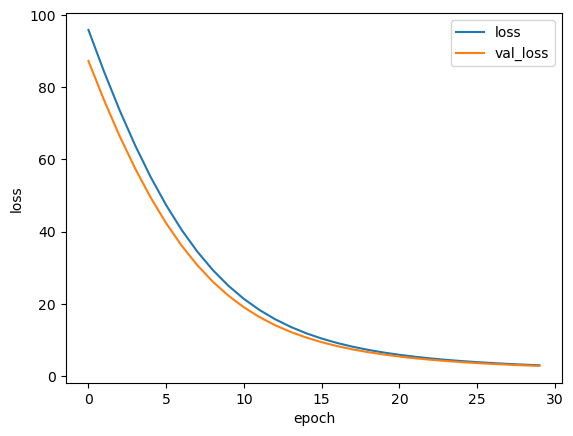

In [11]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.

print("\n\n{}\n\t{}\n{}".format('='*55,f'Train {m_obj.Name} model', '-'*55))

conf.execute_training(
    model, 
    data=train_dataset, 
    saveas=m_obj.Name+'_pets', 
    plot_history=INTERACTIVE_SESSION
)



### Visualize predictions

1/3 [=========>....................] - ETA: 7s

2/3 [===================>..........] - ETA: 3s

3/3 [==============================] - ETA: 0s

3/3 [==============================] - 9s 2s/step


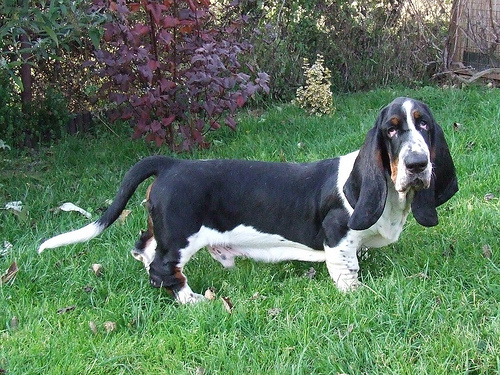

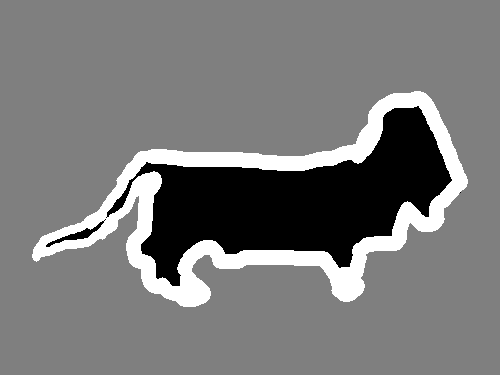

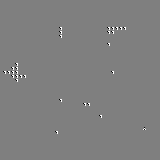

In [12]:
# Generate predictions for all images in the validation set

val_preds = model.predict(valid_dataset)

if INTERACTIVE_SESSION:
    pets.display_sample_image(val_preds, image_id=10)
